In [43]:
import os
import math
import pandas as pd
import numpy as np
import seaborn as sns
from pandas import datetime
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.multioutput import RegressorChain
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV
from functions import *

In [44]:
train = pd.read_csv("../data/train_nocat_hh.csv", index_col = 'tstp')
test = pd.read_csv("../data/test_nocat_hh.csv", index_col = 'tstp')

In [45]:
train = extract_dmhq(train)
test = extract_dmhq(test)

In [46]:
cols = train.columns[:8]

### Creat lag ahead scenarios

In [177]:
ftrain, ttrain = feature_target_construct(train, 96, 96, 24, 48, cols, 2,
                                          wd_on = True, d_on = True,
                                          m_on = True, h_on = True, q_on = True)

ftest, ttest = feature_target_construct(test, 96, 96, 24, 48, cols, 2, 
                                        wd_on = True, d_on = True,
                                        m_on = True, h_on = True, q_on = True)


In [6]:
feature_list = list(ftrain.columns)

### Seeking outliers

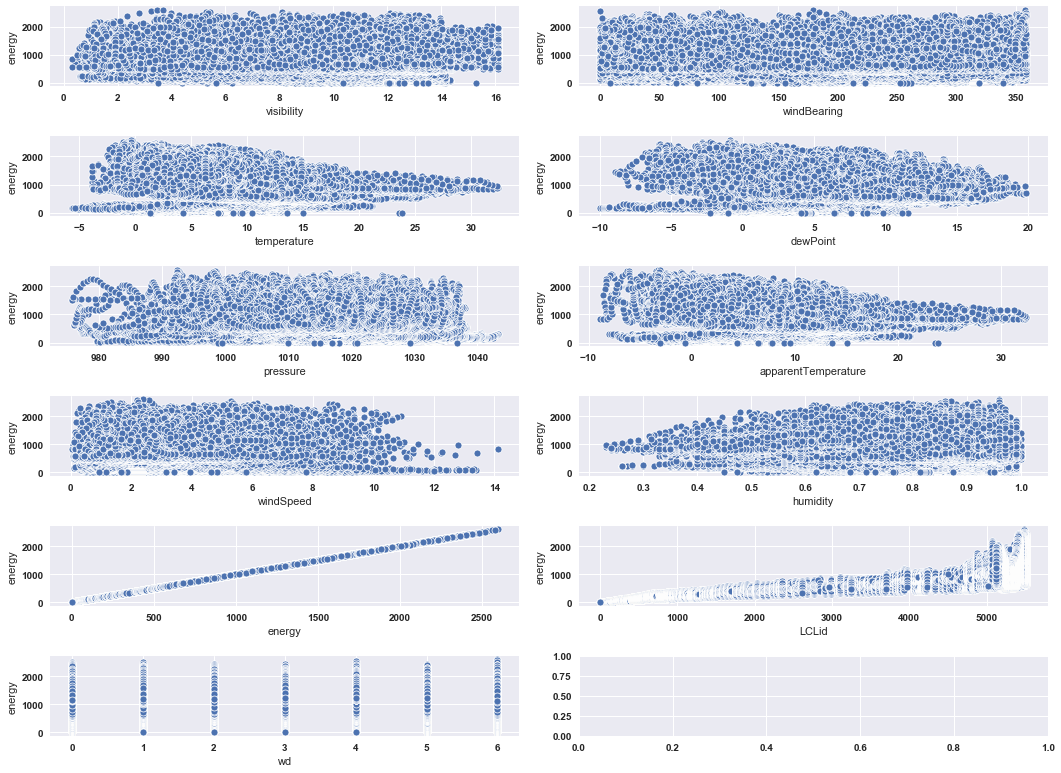

In [145]:
scatter_plot(train)

### Distribution

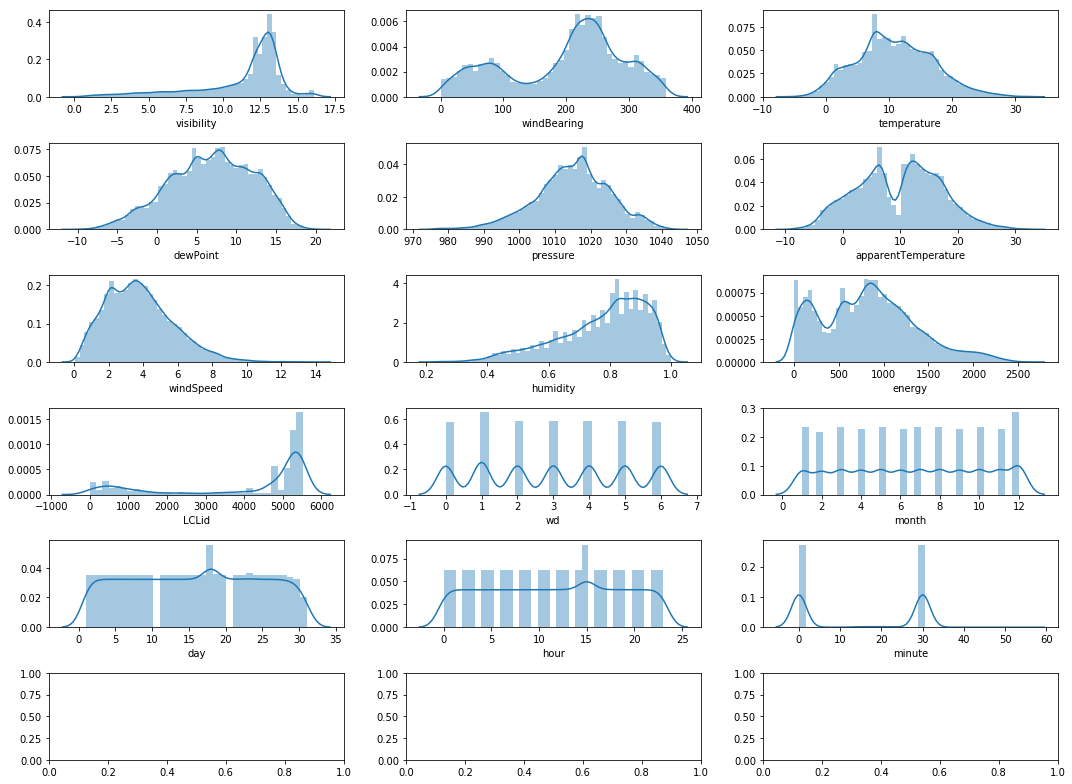

In [7]:
distri_plot(train)

### Feature Selection: Tree-Based

In [48]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel


%time reg = ExtraTreesRegressor(n_estimators = 30).fit(ftrain, ttrain)
#model = SelectFromModel(reg, prefit=True)
#cols = model.get_support(indices=True)
#mt_feature = model.transform(ftrain)

CPU times: user 2min 42s, sys: 1.93 s, total: 2min 44s
Wall time: 2min 45s


In [49]:
# Get numerical feature importances
importances = list(reg.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 3)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
for pair in feature_importances:
    print('Variable: {:20} Importance: {}'.format(*pair))

Variable: LCLid                Importance: 0.286
Variable: hour                 Importance: 0.08
Variable: energy1(t-21)        Importance: 0.049
Variable: energy1(t-17)        Importance: 0.022
Variable: energy1(t-3)         Importance: 0.022
Variable: energy1(t-20)        Importance: 0.021
Variable: energy1(t-35)        Importance: 0.02
Variable: energy1(t-11)        Importance: 0.02
Variable: energy1(t-5)         Importance: 0.02
Variable: energy1(t-6)         Importance: 0.019
Variable: energy1(t-55)        Importance: 0.018
Variable: energy1(t-44)        Importance: 0.018
Variable: energy1(t-15)        Importance: 0.018
Variable: energy1(t-51)        Importance: 0.017
Variable: apparentTemperature1(t+36) Importance: 0.009
Variable: apparentTemperature1(t+24) Importance: 0.006
Variable: apparentTemperature1(t+42) Importance: 0.006
Variable: apparentTemperature1(t+46) Importance: 0.006
Variable: energy1(t-39)        Importance: 0.006
Variable: energy1(t-38)        Importance: 0.006


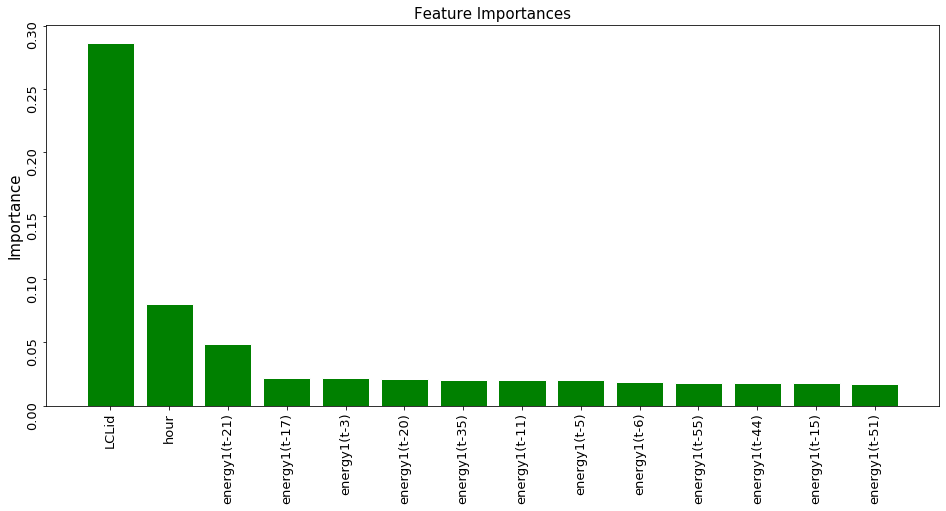

In [50]:
# important features
score = [i[1] for i in feature_importances if i[1] >= 0.01]
picked_features = [i[0] for i in feature_importances if i[1] >= 0.01]
# list of x locations for plotting
x_values = list(range(len(score)))
# Make a bar chart
fig = plt.figure(figsize=(16,7))
font = {'size'   : 15}
plt.rc('font', **font)
plt.bar(x_values, score, orientation = 'vertical', color = 'g', edgecolor = 'w', linewidth = 1)
# Tick labels for x axis
plt.xticks(x_values, picked_features, rotation=90, fontsize = 13)
plt.yticks(rotation='vertical', fontsize = 13)
# Axis labels and title
plt.ylabel('Importance',**font); 
plt.title('Feature Importances',**font);


In [178]:
#pftrain = ftrain[picked_features]
#pftest = ftest[picked_features]
pftrain = ftrain
pftest = ftest

### Scaling 

In [25]:
from sklearn.preprocessing import MinMaxScaler

mmscaler = MinMaxScaler() ## will be used later in test set
mmscaler.fit(ftrain)
pftrain = mmscaler.transform(ftrain)
pftest = mmscaler.transform(ftest)

### Standardization

In [132]:
rng = np.random.RandomState(304)
qt = QuantileTransformer(n_quantiles=500, output_distribution='normal',random_state=rng)
qt.fit(ttrain)
pttrain = qt.transform(ttrain)
pttest = qt.transform(ttest)

### Feature Selection: PCA

In [52]:
from sklearn.decomposition import PCA
pca = PCA(n_components='mle', 
          copy=True,
          whiten=False,
          svd_solver='auto',
          tol=0.0,
          iterated_power='auto',
          random_state=None)
pca.fit(pftrain)
pftrain = pca.transform(pftrain)
pftest = pca.transform(pftest)

In [53]:
pftrain.shape, pftest.shape

((35605, 13), (4418, 13))

### KNN Regression


In [ ]:
from sklearn.neighbors import KNeighborsRegressor
knnr = KNeighborsRegressor(n_neighbors=5, *,
                           weights='uniform', 
                           algorithm='auto', 
                           leaf_size=30, p=2,
                           metric='minkowski', 
                           metric_params=None, 
                           n_jobs=4, **kwargs)

### Extra Trees Regression

In [179]:
from sklearn.ensemble import ExtraTreesRegressor
etr = ExtraTreesRegressor(n_estimators=500, 
                          criterion= 'mse', 
                          max_depth=None, 
                          min_samples_split=5, 
                          min_samples_leaf=4, 
                          min_weight_fraction_leaf=0.0, 
                          max_features='auto', 
                          max_leaf_nodes=None, 
                          min_impurity_decrease=0.0, 
                          min_impurity_split=None, 
                          bootstrap=False, 
                          oob_score=False, 
                          n_jobs=4, 
                          random_state=None, 
                          verbose=0, 
                          warm_start=True, 
                          ccp_alpha=0.3, max_samples=None)
X = pftrain
y = ttrain
#train_X, left_X, train_y, left_y = train_test_split(X, y, train_size = 0.9, shuffle= False)
train_X, val_X, train_y, val_y = train_test_split(X, y, train_size = 0.7, shuffle= True)
%time etr.fit(train_X, train_y)

CPU times: user 22min 16s, sys: 8.22 s, total: 22min 25s
Wall time: 5min 38s


ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.3, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=4,
                    min_samples_split=5, min_weight_fraction_leaf=0.0,
                    n_estimators=500, n_jobs=4, oob_score=False,
                    random_state=None, verbose=0, warm_start=True)

### Validation set

In [180]:
ypred = etr.predict(val_X)
o_y = np.transpose(val_y)
p_y = np.transpose(ypred)
get_eval(o_y, p_y)

MSE: 7019.31091691461
MAE: 40.58618704600008
r2_score: 0.919873312965368


### Testing set

In [181]:
ypred_t = etr.predict(pftest)
o_y = np.transpose(ttest.to_numpy())
p_y = np.transpose(ypred_t)
get_eval(o_y, p_y)

MSE: 8540.02481291171
MAE: 67.31749152388561
r2_score: 0.9454494656179792


In [182]:
r2_list = []
for i in range(ttest.shape[0]):
    o_y = np.transpose(ttest.iloc[i,:].to_numpy())
    p_y = np.transpose(ypred_t[i,:])
    r2 = r2_score(o_y, p_y)
    r2_list.append(r2)

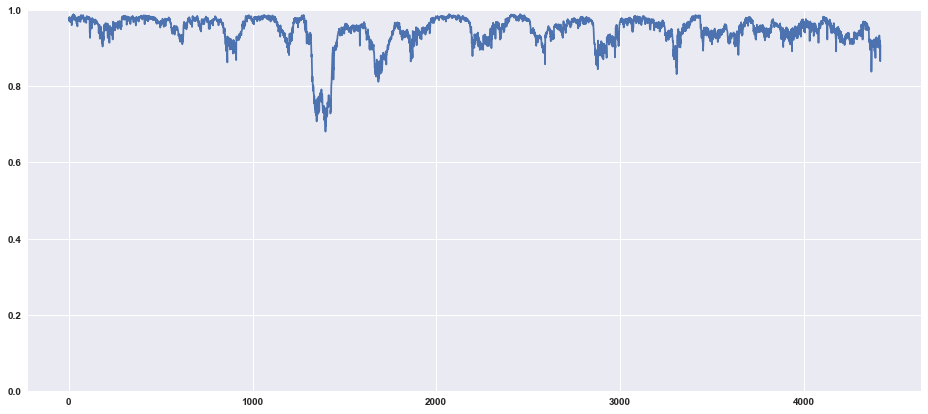

In [183]:
fig = plt.figure(figsize=(16,7))
plt.ylim(0)
plt.plot(r2_list)

### Confidence Interval: np.qunatile

In [184]:
def plot_conf_quantile(val_y, val_y_pred, test_y, test_y_pred, n, ci_term):
    median = np.quantile(val_y - val_y_pred, 0.5, axis = 0)
    ub = np.quantile(val_y - val_y_pred, 1- ci_term, axis = 0)
    lb = np.quantile(val_y - val_y_pred, ci_term, axis = 0)

    ypred_t_ub = test_y_pred  + median + ub
    ypred_t_lb = test_y_pred  + median + lb 
    # plot
    fig = plt.figure(figsize=(16,7))
    font = {'family' : 'Lucida Grande',
            'weight' : 'bold',
            'size'   : 15}
    plt.rc('font', **font)
    plt.style.use('seaborn')
    plt.plot(test_y_pred[n, :].reshape(-1,1), 'gx-',label='Prediction')
    plt.plot(ypred_t_ub[n, :].reshape(-1,1), 'g--', label='{} % upper bond'.format(100-ci_term*100))
    plt.plot(ypred_t_lb[n, :].reshape(-1,1), 'g--', label='{} % lower bond'.format(ci_term*100))
    plt.plot(test_y.iloc[n, :].to_numpy().reshape(-1,1), 'ro', label='Ground truth')
    #plt.fill(np.concatenate([xx, xx[::-1]]),
    #         np.concatenate([y_upper, y_lower[::-1]]),
    #         alpha=.5, fc='b', ec='None', label='90% prediction interval')
    plt.xlabel('hours', **font)
    plt.ylabel('KWh', **font)
    plt.legend(loc='upper left', fontsize = 15)
    plt.show()

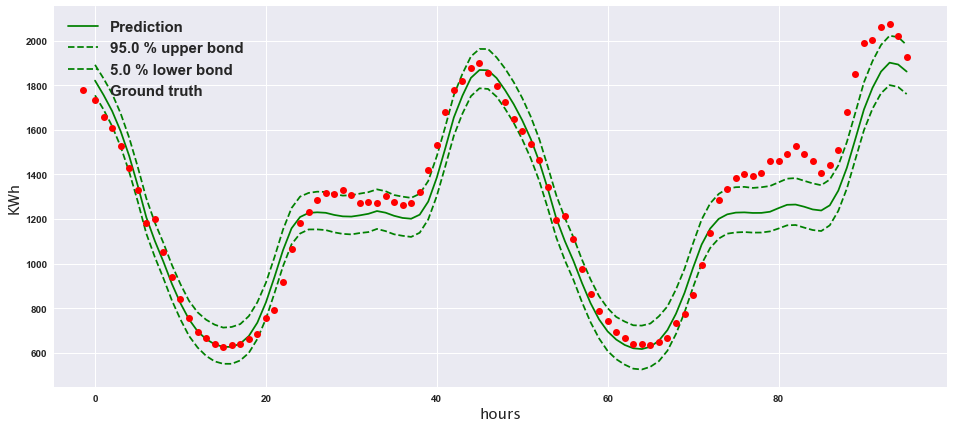

In [193]:
plot_conf_quantile(val_y, ypred, ttest, ypred_t, 185, 0.05)

### Confidence Interval: Static

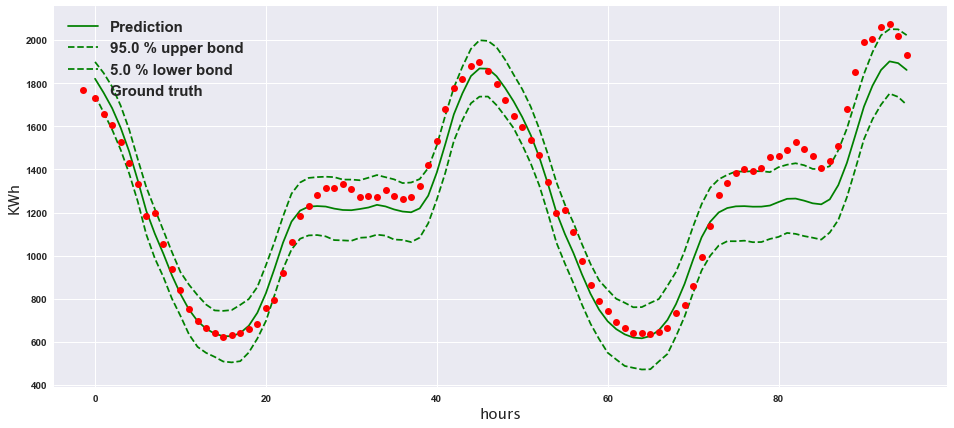

In [186]:
plot_conf_static(val_y, ypred, ttest, ypred_t, 185, 1.)

out_of_bound_pecentage 0.27976190476190477


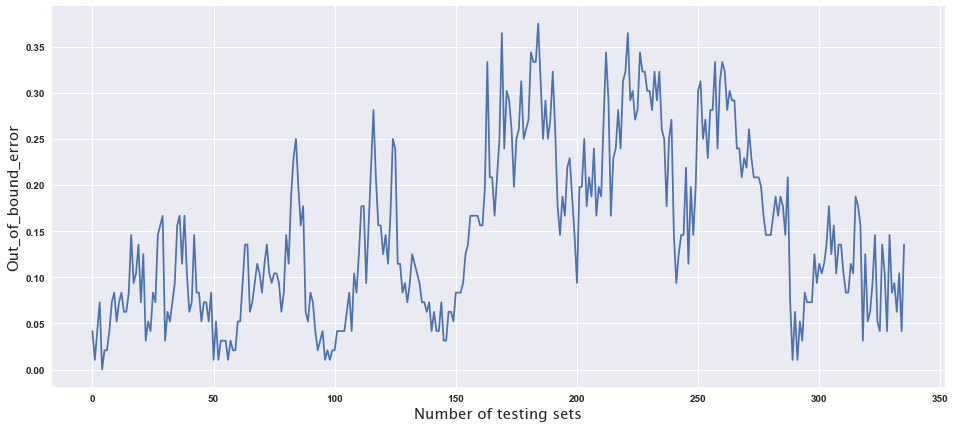

In [189]:
verf_ci_static(1.28, val_y.iloc[:336], ypred[:336], ttest.iloc[:336], ypred_t[:336])

### confidence interval: forest predictors qunatile

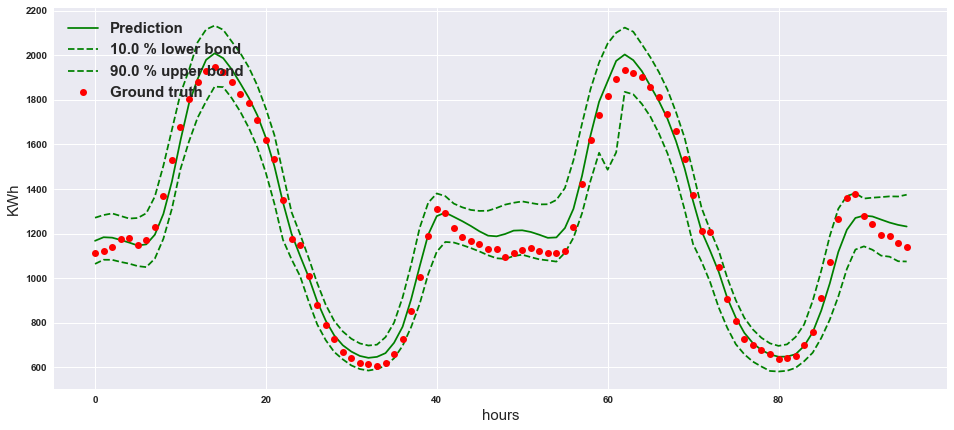

In [204]:
ci_forest(360, 0.1, etr, pftest, ttest)

out_of_bound_pecentage 0.0


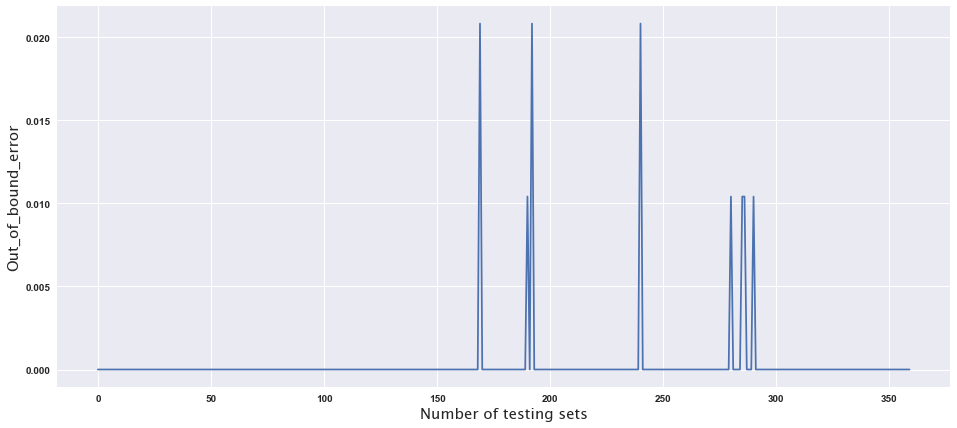

In [195]:
verf_ci_qunatile_forest(0.025, etr, ttest, 360)

### Confidence Interval: dynamic

In [89]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict
err_knn = KNeighborsRegressor(algorithm='auto', leaf_size=20, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=3,
                    weights='uniform')
#scores = cross_val_score(err_knn, val_X, (val_y - ypred), cv = 5, scoring= 'r2', n_jobs = 4)
#print("cross validation scores:", scores)

In [236]:
from sklearn.ensemble import ExtraTreesRegressor
err_etr = ExtraTreesRegressor()
scores = cross_val_score(err_etr, val_X, (val_y - ypred)**2, cv = 5, scoring= 'r2', n_jobs = 4)
print("cross validation scores:", scores)

cross validation scores: [ 0.14660699 -0.58172587 -3.25540463 -0.24779615 -2.6530114 ]


In [122]:
from sklearn.ensemble import RandomForestRegressor
err_rfr = RandomForestRegressor()
scores = cross_val_score(err_rfr, val_X, (val_y - ypred)**2, cv = 5, scoring= 'r2', n_jobs = 4)
print("cross validation scores:", scores)

cross validation scores: [ 0.23419848  0.33726216  0.14079612 -0.29860155 -0.03461351]


In [90]:
err_knn.fit(val_X, (val_y - ypred)**2)
perrorsq = err_knn.predict(pftest)

In [276]:
err_etr.fit(val_X, (val_y - ypred)**2)
perrorsq = err_etr.predict(pftest)

In [279]:
err_rfr.fit(val_X, (val_y - ypred)**2)
perrorsq = err_rfr.predict(pftest)

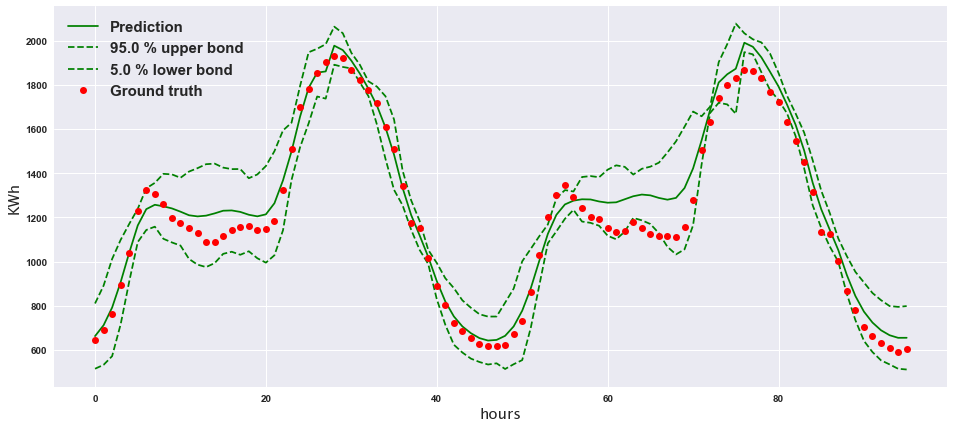

In [338]:
plot_conf_dynamic(perrorsq, ttest, ypred_t, 10, 1.645)

out_of_bound_pecentage 0.15


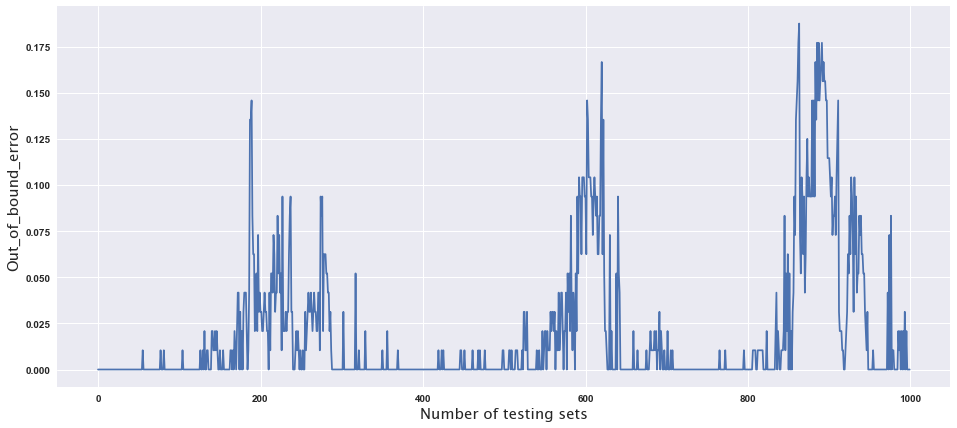

In [93]:
verf_ci_dynamic(1.96, np.sqrt(np.std(perrorsq, axis = 0)), ttest.iloc[:1000,:], ypred_t[:1000,:])

### HistGradientBoostingRegression

In [249]:
from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import HistGradientBoostingRegressor
hgb = HistGradientBoostingRegressor(loss='least_squares', 
                                    learning_rate=0.1, 
                                    max_iter=100, 
                                    max_leaf_nodes=3, 
                                    max_depth=None, 
                                    min_samples_leaf=20, 
                                    l2_regularization=0.0, 
                                    max_bins=80, 
                                    warm_start=False, 
                                    scoring=None, 
                                    validation_fraction=0.1, 
                                    n_iter_no_change=None, 
                                    tol=1e-07, 
                                    verbose=0, 
                                    random_state=None)
mhgb = RegressorChain(hgb)


In [250]:
from sklearn.model_selection import train_test_split
X = pftrain
y = ttrain
train_X, val_X, train_y, val_y = train_test_split(X, y, train_size = 0.7, test_size = 0.3)

%time mhgb.fit(train_X, train_y)

CPU times: user 4min 53s, sys: 17.5 s, total: 5min 11s
Wall time: 52.6 s


RegressorChain(base_estimator=HistGradientBoostingRegressor(l2_regularization=0.0,
                                                            learning_rate=0.1,
                                                            loss='least_squares',
                                                            max_bins=80,
                                                            max_depth=None,
                                                            max_iter=100,
                                                            max_leaf_nodes=3,
                                                            min_samples_leaf=20,
                                                            n_iter_no_change=None,
                                                            random_state=None,
                                                            scoring=None,
                                                            tol=1e-07,
                                                            validat

### Validation set

In [256]:
ypred = mhgb.predict(val_X)

In [257]:
o_y = np.transpose(val_y.iloc[:,:].to_numpy())
p_y = np.transpose(ypred[:,:])
get_eval(o_y, p_y)

MSE: 22206.00745651168
MAE: 93.0692047249096
r2_score: 0.7840358638471235


### Testing set

In [258]:
ypred_t = mhgb.predict(pftest)

In [259]:
o_yt = np.transpose(ttest.iloc[:,:].to_numpy())
p_yt = np.transpose(ypred_t[:,:])
get_eval(o_yt, p_yt)

MSE: 14840.849353798356
MAE: 88.91114028008235
r2_score: 0.9052021181825178


**Create Std: static method**

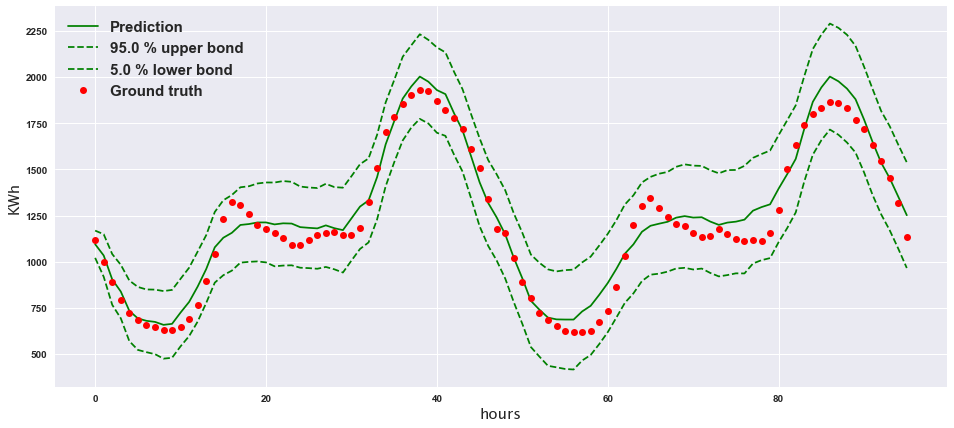

In [260]:
plot_conf_static(val_y, ypred, ttest, ypred_t, 0, 1.645)

out_of_bound_pecentage 0.26414667270258035


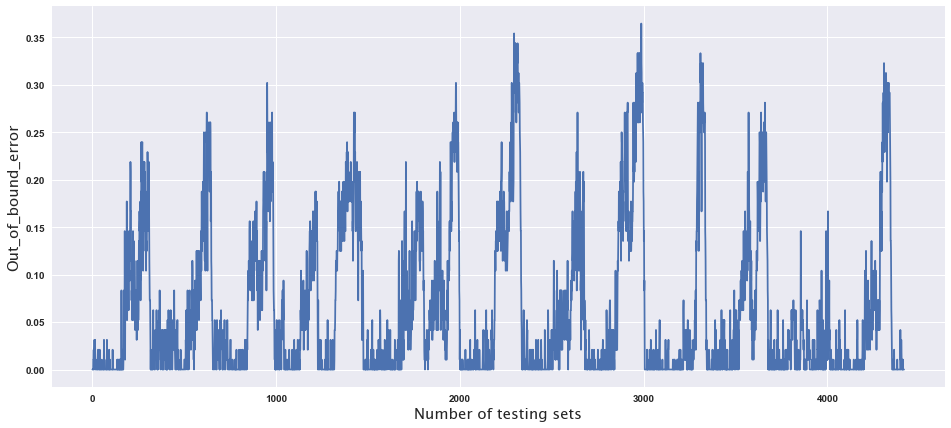

In [262]:
verf_ci_static(1.645, val_y.iloc[:,:], ypred[:,:], ttest.iloc[:,:], ypred_t[:,:])

**Create Std: fit error method**

In [263]:
err_knn = KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')
err_knn.fit(val_X, (val_y- ypred)**2)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

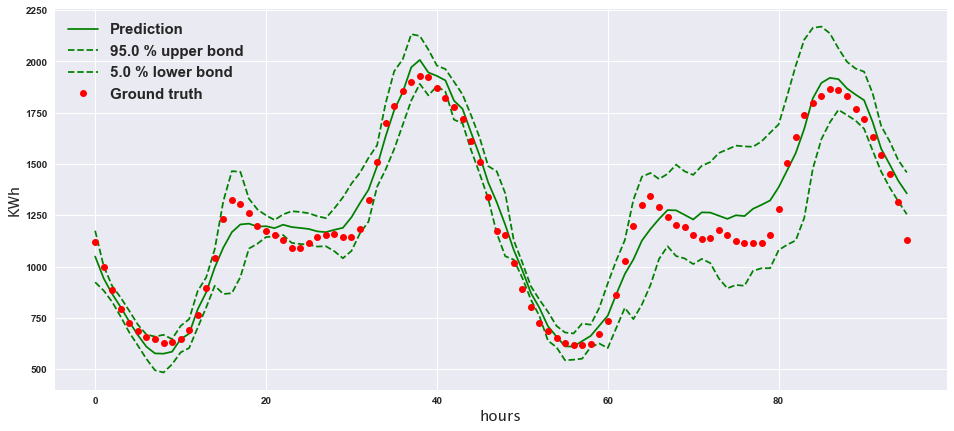

In [478]:
perrorsq = err_knn.predict(pftest)
plot_conf_dynamic(perrorsq, ttest, ypred_t, 0, 1.645)

### Random Forest Regression

In [559]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
rfr = RandomForestRegressor(max_depth=15, random_state=1, n_estimators=100)

X = pftrain
y = ttrain
train_X, val_X, train_y, val_y = train_test_split(X, y, train_size = 0.7, test_size = 0.3)

%time rfr.fit(train_X, train_y)


CPU times: user 2min 52s, sys: 1.09 s, total: 2min 54s
Wall time: 2min 54s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=15, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

In [560]:
ypred = rfr.predict(val_X)
get_eval(val_y, ypred)

MSE: 9095.299929526684
MAE: 48.630765033709714
r2_score: 0.9667695358962971


In [561]:
ypred_t = rfr.predict(pftest)
get_eval(ttest, ypred_t)

MSE: 10156.267108542155
MAE: 74.08968016832176
r2_score: 0.9361177915083578


### Confidence interval:static

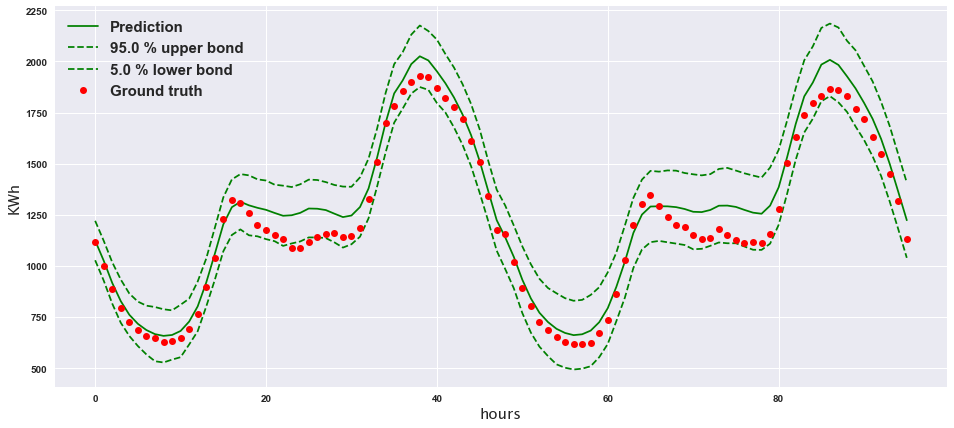

In [562]:
plot_conf_static(val_y, ypred, ttest, ypred_t, 0, 1.645)

### Confidence interval:dynamic

**KNN**

In [563]:
err_knn = KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')
err_knn.fit(val_X, (val_y - ypred)**2)
err_knn.score(val_X, (val_y - ypred)**2)

//miniconda3/envs/tpot/lib/python3.6/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.5187379760149411

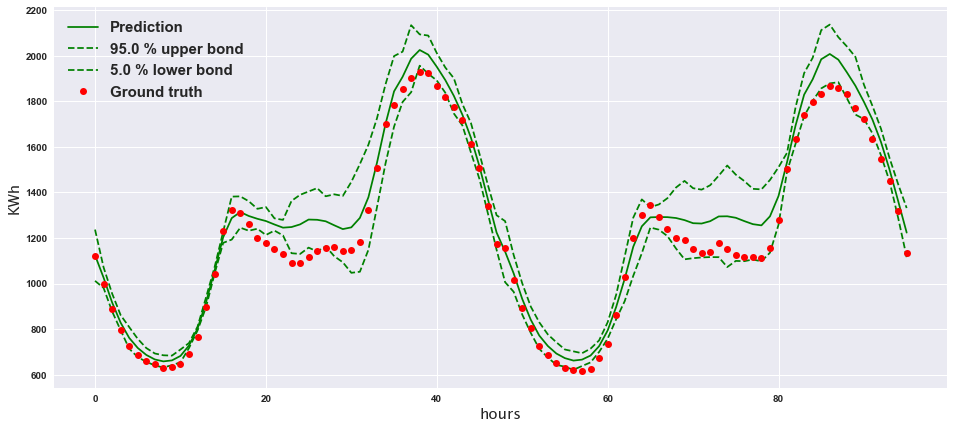

In [564]:
yhat = err_knn.predict(pftest.iloc[0,:].to_numpy().reshape(1,-1))
plot_conf_dynamic(yhat, ttest, ypred_t, 0, 1.645)

**ExtraTrees**


In [565]:
err_etr = ExtraTreesRegressor()
err_etr.fit(val_X, (val_y - ypred)**2)
err_etr.score(val_X, (val_y - ypred)**2)

//miniconda3/envs/tpot/lib/python3.6/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


1.0

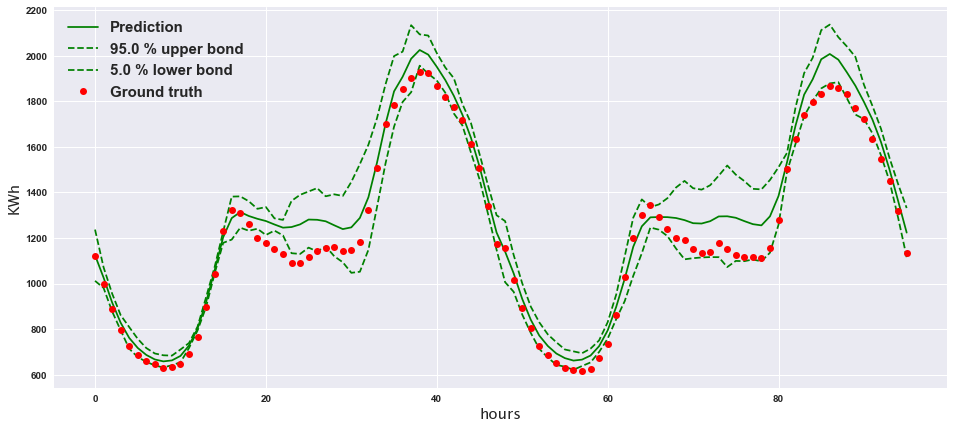

In [567]:
yhat = err_knn.predict(pftest.iloc[0,:].to_numpy().reshape(1,-1))
plot_conf_dynamic(yhat, ttest, ypred_t, 0, 1.645)



### Xgboost: Manual

In [500]:
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor

X = pftrain
y = ttrain
train_X, val_X, train_y, val_y = train_test_split(X, y, train_size = 0.7, test_size = 0.3)

xgbr = xgb.XGBRegressor(max_depth=10, njobs= 4)
mr = MultiOutputRegressor(xgbr, n_jobs = 4)
mr.fit(train_X, train_y)
#rc = MultiOutputRegressor(xgbr, cv = 5, random_state = 123)
#rc.fit(train_X, train_y)

MultiOutputRegressor(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            importance_type='gain',
                                            learning_rate=0.1, max_delta_step=0,
                                            max_depth=10, min_child_weight=1,
                                            missing=None, n_estimators=100,
                                            n_jobs=1, njobs=4, nthread=None,
                                            objective='reg:linear',
                                            random_state=0, reg_alpha=0,
                                            reg_lambda=1, scale_pos_weight=1,
                                            seed=None, silent=None, subsample=1,
                                        

### Result evaluation: validation set

In [513]:
yhat = mr.predict(val_X)

In [502]:
get_eval(val_y, yhat)

MSE: 7765.100654935687
MAE: 44.55453092189882
r2_score: 0.9712537126596072


### Result evaluation: test set

In [503]:
ypred = mr.predict(pftest)

In [504]:
get_eval(ttest, ypred)

MSE: 10175.073762555183
MAE: 70.17073013698152
r2_score: 0.935999498972345


### Confidnece interval: Static

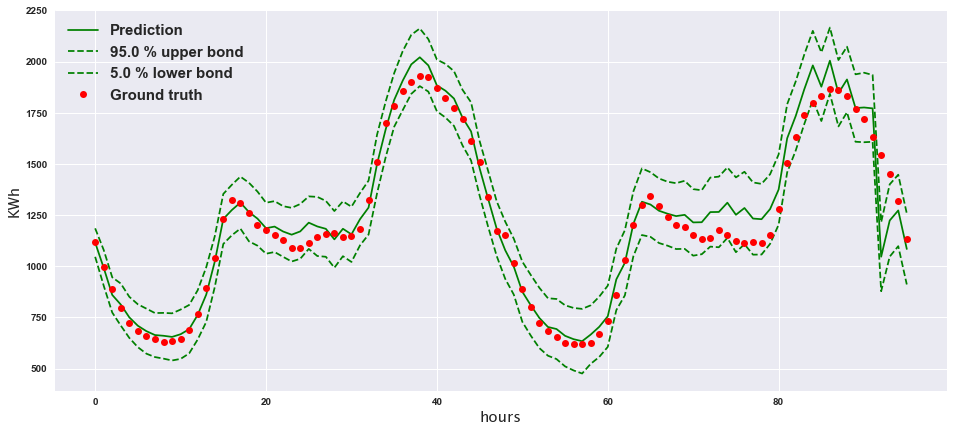

In [508]:
plot_conf_static(val_y, yhat, ttest, ypred, 0, 1.645)

### Confidence Interval: dynamic

In [599]:
from sklearn.model_selection import cross_val_score, cross_val_predict
err_knn = KNeighborsRegressor(algorithm='auto', leaf_size=20, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=3,
                    weights='uniform')
scores = cross_val_score(err_knn, val_X, (val_y - yhat)**2, cv = 10, scoring= 'r2' ,n_jobs = 4)
print("cross validation scores:", scores)

cross validation scores: [0.94346122 0.94695128 0.94615383 0.94496561 0.94323953 0.94689917
 0.92899007 0.9450479  0.94872416 0.94161291]


In [600]:
err_etr = ExtraTreesRegressor()
etr_scores = cross_val_score(err_etr, val_X, (val_y - yhat)**2, cv = 5, scoring= 'r2' ,n_jobs = 4)
print("cv r2_scores:", etr_scores)
predictions = cross_val_predict(err_etr, val_x, (val_y - yhat)**2)

//miniconda3/envs/tpot/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


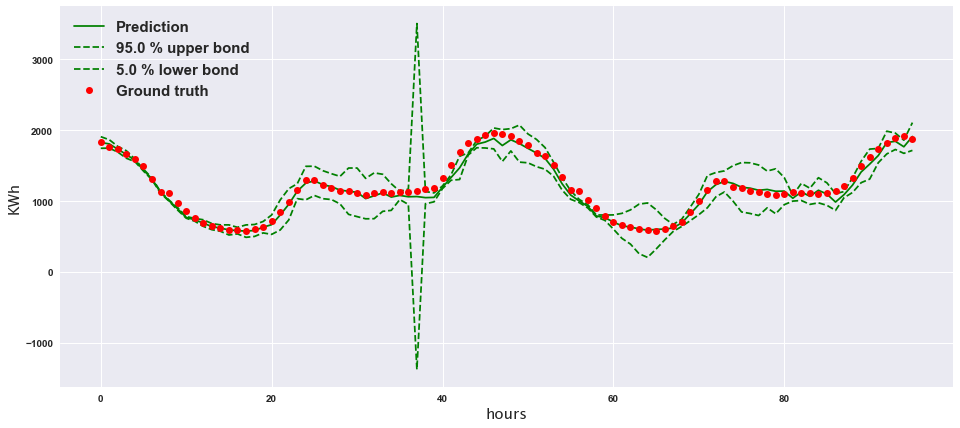

In [544]:
yhat = err_knn.predict(pftest.iloc[0,:].to_numpy().reshape(1,-1))
plot_conf_dynamic(yhat, ttest, ypred, 1000, 1.645)

### LSTM

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 50)             14200     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 96)             4896      
Total params: 19,096
Trainable params: 19,096
Non-trainable params: 0
_________________________________________________________________

Epoch 1/50
 - 3s - loss: 907187.9891
Epoch 2/50
 - 2s - loss: 582957.2942
Epoch 3/50
 - 2s - loss: 340729.4832
Epoch 4/50
 - 2s - loss: 268444.2695
Epoch 5/50
 - 2s - loss: 238410.4348
Epoch 6/50
 - 2s - loss: 212033.8502
Epoch 7/50
 - 2s - loss: 188070.4098
Epoch 8/50
 - 2s - loss: 167425.9583
Epoch 9/50
 - 2s - loss: 150808.0975
Epoch 10/50
 - 2s - loss: 138048.8542
Epoch 11/50
 - 2s - loss: 127697.5308
Epoch 12/50
 - 2s - loss: 118425.3864
Epoch 13/50
 - 2s - loss: 109641.9108
Epoch 14/50
 - 2s - loss: 

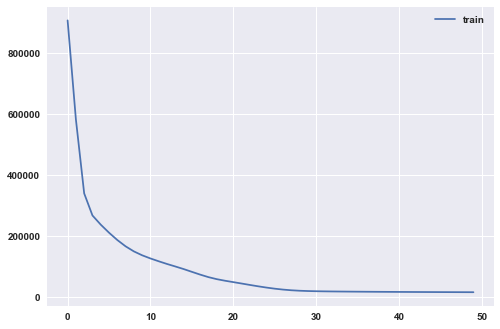

In [418]:
from keras.layers import TimeDistributed
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

train_X, val_X, train_y, val_y = train_test_split(pftrain, ttrain, train_size = 0.7, test_size = 0.3)
ltrain_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
lval_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
ltrain_y = train_y.to_numpy().reshape((train_y.shape[0],1, train_y.shape[1]))

# design network
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(ltrain_X.shape[1], ltrain_X.shape[2]),return_sequences = True))
model.add(TimeDistributed(Dense(96)))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
# fit network
history = model.fit(ltrain_X, ltrain_y, epochs=50, batch_size=72, verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

### Validation sets

**Metrics**


In [419]:
yhat = model.predict(val_X.reshape(val_X.shape[0], 1, val_X.shape[1]))
yhat = yhat.reshape(yhat.shape[0], yhat.shape[2])

In [420]:
get_eval(val_y, yhat)

MSE: 18339.820647197208
MAE: 74.85561810425645
r2_score: 0.9317110281105421


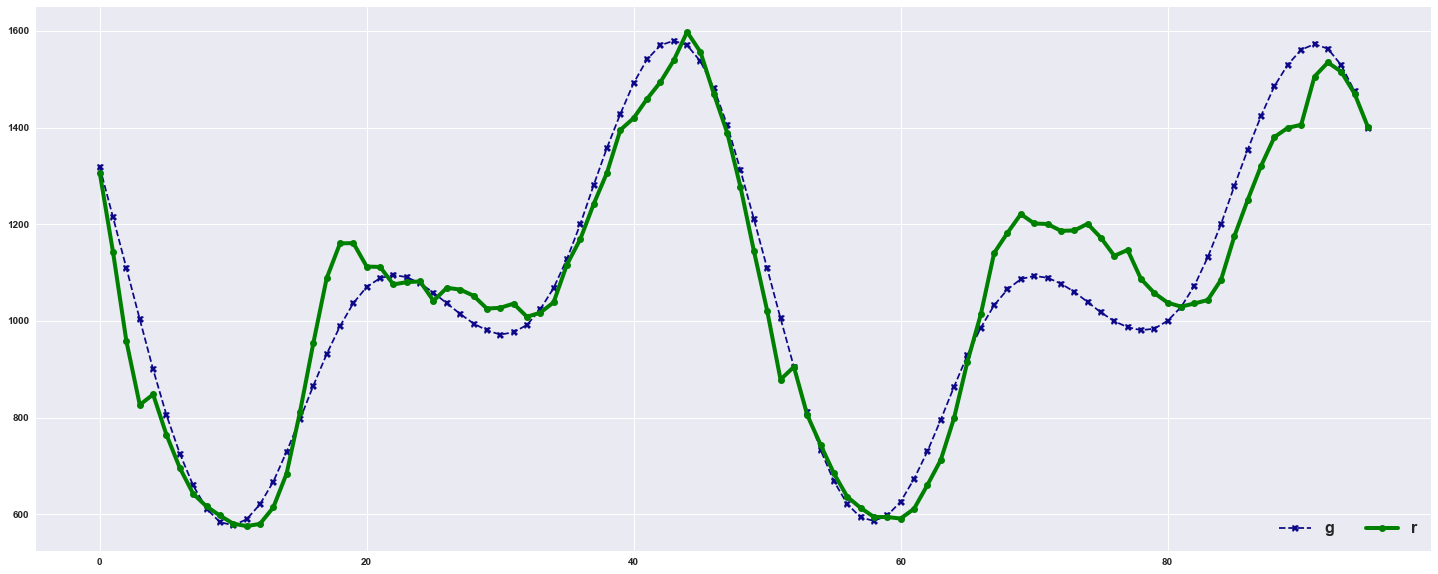

In [421]:
real = val_y.to_numpy()
guess = yhat
real = real[1:2,:96]
guess = guess[1:2,:96]
rpdf = plot_df(real,"r")
gpdf = plot_df(guess,"g")
    
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'plasma',style='--X',legend = True, ax = ax)
rpdf.plot(figsize=(25,10), color = 'g',style ='-o',legend = True, ax = ax,lw = 4)
ax.legend(frameon=False, loc='lower right', ncol=6, prop={'size': 16})
    
plt.show()

### Testing sets

In [425]:
test_x = pftest
yhat = model.predict(test_x.reshape(test_x.shape[0], 1, test_x.shape[1]))
yhat = yhat.reshape(yhat.shape[0], yhat.shape[2])

**Metrics**

In [426]:
test_y = ttest
get_eval(test_y.iloc[:1,:].to_numpy().reshape(-1,1), yhat[:1,:].reshape(-1,1))

MSE: 6897.72371174048
MAE: 63.57475920141602
r2_score: 0.9531105547594014


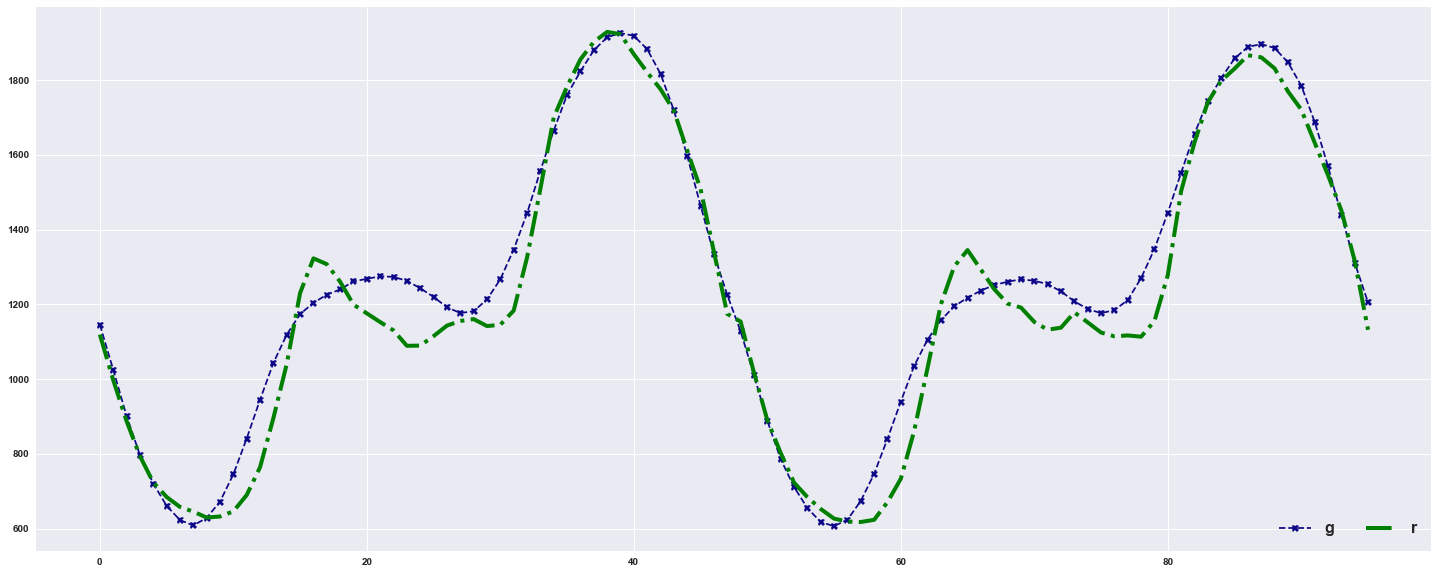

In [427]:
real = test_y.to_numpy()
guess = yhat
real = real[0:1,:96]
guess = guess[0:1,:96]
rpdf = plot_df(real,"r")
gpdf = plot_df(guess,"g")
    
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'plasma',style='--X',legend = True, ax = ax)
rpdf.plot(figsize=(25,10), color = 'g',style ='-.',legend = True, ax = ax,lw = 4)
ax.legend(frameon=False, loc='lower right', ncol=6, prop={'size': 16})
    
plt.show()